<div style="text-align: right">ADEC7430 Lecture 2</div>
<div style="text-align: right">Prof. Stefano Parravano, 09/02/2025</div>

## OLS: Different Perspective

In [2]:
import torch

Consider two lists: 
$$ t_c = [7.3, 15.1, 17.2, 61.9, 12.3, 8.0, 11.6, 22.5,6.0, 16.6, 32.2] $$    
and  
$$ t_f =[35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] $$ 

Treat them as results of a series of measurement. Your objective is to make      quadratic models that would predict variable t_c, given values of variable t_f.


### Problem 1 Solution

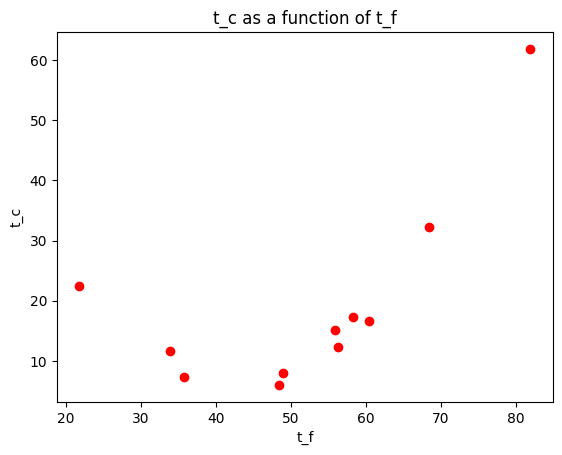

In [3]:
t_c = [7.3, 15.1, 17.2, 61.9, 12.3, 8.0, 11.6, 22.5,6.0, 16.6, 32.2]
t_f = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_f = torch.tensor(t_f)

import numpy as np
import matplotlib.pyplot as plt


plt.plot(t_f, t_c, "ro")   
plt.title('t_c as a function of t_f')  
plt.xlabel('t_f')  
plt.ylabel('t_c')  
#plt.legend() 
plt.show()

A quadratic realtionship seems plausible here. At this point we should also recall that a univariate quadratic function (univariate here because we have one feature) has the form : 

$$ f(x) = ax^2 + bx + c $$  
where:  
$$ (a,b,c) \in \mathbf{R}$$  
and of course let's not forget:  
$$ a \neq 0 $$  

In the context of our problem here we can write the following:  

$$ t_p = ax^2 + bx + c $$  
where we think of $t_p$ as the predicted value of $t_t$ for some input $t_f$.  

If we are interested in fitting a curve between our points we can think of defining our standard loss function as:  

$$ L =\frac {1}{N} \sum_{i=1}^n(\overline{Y_i} - Y_i)^2 $$  

We can replace key vaiables of this Standard loss function with those that are specific to our problem:
$$ L =\frac {1}{N} \sum_{}(t_p - t_c)^2 $$  
we can follow this with another round of substitutions:    
$$ L =\frac {1}{N} \sum_{}((ax^2 + bx + c) - t_c)^2 $$  
To enable an easy walkthough of the gradient math that we need to perform, I will 'split' our loss function into smaller parts by writing it as the composition of smaller (easier) functions.  
Let:
$$ m = ax^2 + bx + c - t_c $$  
we can $\therefore$ write $L$ as:    
$$ L = \frac {1}{N} \sum_{}m^2 $$  

Suddendly L is an extremely nice looking function that we will be able to differentiate without any problems. Before we start computing any derivatives we need to take stock of what paramters our model will have. It should be clear that we will have 3 trainable paramters: $a$,$b$,$c$. The gradient of $L$ , keeping in mind the chain rule can be written as:  
$$ \nabla_{a,b,c} L = \langle \frac{\partial L}{\partial m} \frac{\partial m}{\partial a}, \frac{\partial L}{\partial m} \frac{\partial m}{\partial b}, \frac{\partial L}{\partial m} \frac{\partial m}{\partial c} \rangle $$  

Our job now is to compute each of the partials in the expressions above. Don't let the notation fool you, this is a very simple problem, and is suprisingly elementary from a mathematical standpoint.  

$$ \frac{\partial L}{\partial m}= \frac{1}{n} \cdot 2m $$
$$ \frac{\partial m}{\partial a}= {t_f}^2 $$
$$ \frac{\partial m}{\partial b}= t_f $$
$$ \frac{\partial m}{\partial c}= 1 $$  

$$ \nabla_{a,b,c} L = \langle \frac{1}{n}\cdot 2m({t_f}^2), \frac{1}{n}(2m) \cdot t_f,\frac{1}{n}(2m)\rangle $$  

We can now convert this into code and use gradient descent to compute the optimal paramters a,b,c that will define our functional mapping of the experimental data we have.  
Note: I have dropped the sigma to make the notation easier. We compute values for the gradient for each sample, thereby generating a gradient vector for each compnent listed above. We then sum each component vector to generate three real numbers. We then 'nudge' each paramter using these three scalars.

In [4]:
#let's define our loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()
#we can take the derivative of our loss function. Note this is where we substituded and made L= m^2
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs

def model(t_f, a, b,c):
    #let's make sure our input get's ocnverted to a tensor
    #t_f=torch.FloatTensor(t_f)
    res = a * (t_f)**2  + b * t_f + c
    return (res)

# Since t_p = model(a, b,c), the derivatives of t_p with respect to a,b  and c are given by:
def dmodel_da(t_f, a, b,c):
    res = t_f **2
    return (res)

def dmodel_db(t_f, a, b,c):
    res = t_f
    return (res)

def dmodel_dc(t_f, a, b,c):
    res = 1.0
    return (res)

#now we can build out the gradient function that will perform the math we outlined above
def grad_fn(t_f, t_c, t_p,a,b,c):
    dloss_da = dloss_fn(t_p, t_c) * dmodel_da(t_f,a,b,c)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_f,a,b,c)
    dloss_dc = dloss_fn(t_p, t_c) * dmodel_dc(t_f,a,b,c)
    return torch.stack([dloss_da.mean(), dloss_db.mean(),dloss_dc.mean()])

#now as a last step we write the code for the iterative part of gradient descent. We compute the gradient
#nudge our parameters in the opposite direction and update our paramters with the new values and we keep
#repeating this process till a stopping criteria is reached. nothing mroe complicataed than that

def training_loop(n_epochs, learning_rate, params, t_f, t_c, print_params=True):
    loss_values=[]
    epoch_list=[]
    for epoch in range(1, n_epochs + 1):
        a,b,c = params

        t_p = model(t_f, a, b,c)  #  Forward pass
        loss = loss_fn(t_p, t_c)
        #gradient = grad_fn(t_f, t_c, t_p, a, b,c)#  Backward pass
        gradient = grad_fn(t_f, t_c, t_p,*params)
        params = params - learning_rate * gradient
        loss_values.append(loss)
        epoch_list.append(epoch)
        if epoch % 4000 ==0 :
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            #print('Grad:',gradient,'Params',params)
        elif epoch in [x for x in range(2)]:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            #print('Grad:',gradient,'Params',params)
        if not torch.isfinite(loss).all():
            break  # <3>
    
    loss_history=list(zip(epoch_list,loss_values))
    return (params,loss_history)

We are ready to find our optimal paramters a,b,c via gradient descent.  
Let's normalize our inputs and then start **training**.

In [5]:
def normalize_tensor_0_1(tensor):
    min_ten=min(tensor)
    max_ten=max(tensor)
    norm_ten=(tensor - min_ten)/(max_ten-min_ten)
    return(norm_ten)
def reverse_normalize_tensor_0_1(tensor,norm_tensor):
    min_ten=min(tensor)
    max_ten=max(tensor)
    ten=norm_tensor*(max_ten-min_ten)+min_ten
    return(ten)

We can start training !

In [6]:
import random
random.uniform(0, 1)
a,b,c = random.uniform(0, 1),random.uniform(0, 1),random.uniform(0, 1)
print('Initial values for parameters (a,b,c)=:',a,b,c)
tf_normalized = normalize_tensor_0_1(t_f)
import time
start_time=time.time()
params,loss_history = training_loop(
    n_epochs = 100_000, 
    learning_rate = 1e-2, 
    params = torch.tensor([a, b,c]), 
    t_f = tf_normalized, 
    t_c = t_c,
    print_params = False)
end_time=time.time()
total_train_time=end_time-start_time
print('Total train time:',total_train_time)
#let's make our predictions and then inverser the normalization

Initial values for parameters (a,b,c)=: 0.012492104397071602 0.3723401121546104 0.9617408599869594
Epoch 1, Loss 556.392761
Epoch 4000, Loss 54.254627
Epoch 8000, Loss 29.942511
Epoch 12000, Loss 16.956079
Epoch 16000, Loss 10.019322
Epoch 20000, Loss 6.314049
Epoch 24000, Loss 4.334883
Epoch 28000, Loss 3.277680
Epoch 32000, Loss 2.712977
Epoch 36000, Loss 2.411315
Epoch 40000, Loss 2.250123
Epoch 44000, Loss 2.164085
Epoch 48000, Loss 2.118078
Epoch 52000, Loss 2.093497
Epoch 56000, Loss 2.080382
Epoch 60000, Loss 2.073342
Epoch 64000, Loss 2.069545
Epoch 68000, Loss 2.067503
Epoch 72000, Loss 2.066418
Epoch 76000, Loss 2.065788
Epoch 80000, Loss 2.065502
Epoch 84000, Loss 2.065309
Epoch 88000, Loss 2.065201
Epoch 92000, Loss 2.065154
Epoch 96000, Loss 2.065139
Epoch 100000, Loss 2.065139
Total train time: 27.979370832443237


In [7]:
print(f"{a},{b},{c}")
print(params)

0.012492104397071602,0.3723401121546104,0.9617408599869594
tensor([130.6685, -90.7532,  22.5796])


We can visualize our resutls now..  
 1. We first will make predictions using the model we just trained (remember to use normalized values for the predictor)  
 2. We will create a zipped list of t_p and t_f and sort by t_f (this will enable us to draw a nice line graph)
 3. We will plot our results and perform some very basic error disgnostics.  
 

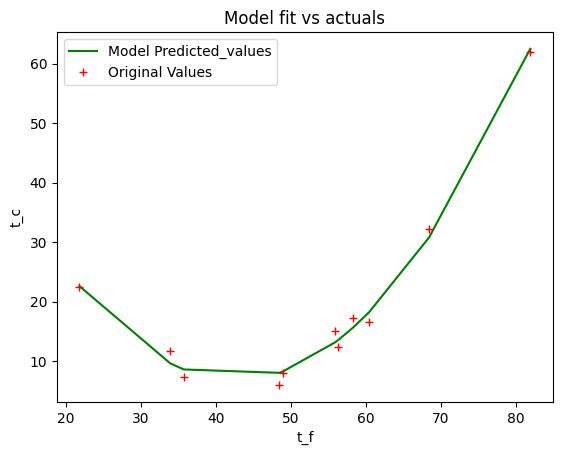

In [8]:
t_p1 = model(tf_normalized, *params) 
from matplotlib import pyplot as plt
import operator
zipped=list(zip(list(t_f.numpy()),list(t_p1.numpy())))
sorted_list=sorted(zipped,key=operator.itemgetter(0))

t_f_sort=[x for x,y in sorted_list]
t_p1_sort=[y for x,y in sorted_list]

plt.title('Model fit vs actuals')  
plt.xlabel("t_f")
plt.ylabel("t_c")
plt.plot(t_f_sort, t_p1_sort,'g',label='Model Predicted_values')  #, t_p.detach().numpy()) 
plt.plot(t_f.numpy(), t_c.numpy(), 'r+',label='Original Values')
plt.legend() 
plt.show()

In [9]:
for x in range(len(t_p1)):
    print(f"Predicted value: {t_p1[x]}, Actual value: {t_c[x]}, Input value: {t_f[x]}")

Predicted value: 8.579702377319336, Actual value: 7.300000190734863, Input value: 35.70000076293945
Predicted value: 13.153337478637695, Actual value: 15.100000381469727, Input value: 55.900001525878906
Predicted value: 15.546213150024414, Actual value: 17.200000762939453, Input value: 58.20000076293945
Predicted value: 62.494964599609375, Actual value: 61.900001525878906, Input value: 81.9000015258789
Predicted value: 13.541997909545898, Actual value: 12.300000190734863, Input value: 56.29999923706055
Predicted value: 8.225740432739258, Actual value: 8.0, Input value: 48.900001525878906
Predicted value: 9.604724884033203, Actual value: 11.600000381469727, Input value: 33.900001525878906
Predicted value: 22.579622268676758, Actual value: 22.5, Input value: 21.799999237060547
Predicted value: 8.009431838989258, Actual value: 6.0, Input value: 48.400001525878906
Predicted value: 18.193201065063477, Actual value: 16.600000381469727, Input value: 60.400001525878906
Predicted value: 30.7705

In [10]:
from sympy import *
residual_vector = Matrix(t_c - t_p1)
residual_vector.norm()

4.76619

In [11]:
def rmse_error(actuals,predicted):
    error=[x-y for x,y in zip(actuals,predicted)]
    sq_error=[x*x for x in error]
    sum_sq_error=sum(sq_error)
    mse = sum_sq_error/len(sq_error)
    rmse = mse**0.5
    return(rmse)

def mape_error(actuals,predicted):
    error=[x-y for x,y in zip(actuals,predicted)]
    relative_error=[x/y for x,y in zip(error,actuals)]
    abs_relative_error=[abs(x) for x in relative_error]
    sum_abs_rel_error=sum(abs_relative_error)
    mape=(sum_abs_rel_error/len(actuals))*100
    return(mape)

In [12]:
rmse=rmse_error(t_c,t_p1)
print('On average our preidctions were off by +/-',rmse,'units')

mape=mape_error(t_c,t_p1)
print('On average our preidctions were off by +/-',mape,'percent')

On average our preidctions were off by +/- tensor(1.4371) units
On average our preidctions were off by +/- tensor(10.8181) percent


The error metrics confirm what we seen in the plot. This function that we found via gradient descent does in fact fit our data pretty well.